In [1]:

# Install dependencies (uncomment below if not installed)
%pip install git+https://github.com/openai/whisper.git
%pip install datasets transformers torchaudio jiwer accelerate

import torch
device = torch.device("cpu")
print("Using CPU")


  Cloning https://github.com/openai/whisper.git to c:\users\bijay tamang\appdata\local\temp\pip-req-build-kv1yo_6q
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=813318 sha256=2bd6b893cbf31cb01c7af8b13a5d1eb545a1ac3d28d79aefae430422a8985af2
  Stored in directory: C:\Users\Bijay Tamang\AppData\Local\Temp\pip-ephem-wheel-cache-gs93gm3o\wheels\1f\1d\98\9583695e6695a6ac0ad42d87511097dce5ba486647dbfecb0e
Successfully built openai-whisper
  Attempting uninstall: openai-whisper
    Found existing installation: openai-whisper 20

  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\Bijay Tamang\AppData\Local\Temp\pip-req-build-kv1yo_6q'


Note: you may need to restart the kernel to use updated packages.
Using CPU


In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from datasets import Dataset, Audio
import evaluate  # Use the evaluate package directly instead of datasets.load_metric
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperFeatureExtractor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import librosa
import time
import json
from IPython.display import Audio as IPythonAudio

c:\Users\Bijay Tamang\Desktop\Nepali-Subtitle-Generator\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Step 2: Load and prepare your dataset
import os
import pandas as pd
dataset_path = r"data\public_datasets\merged_dataset"

# Check if dataset folder exists
if not os.path.exists(dataset_path):
    print(f"Dataset path {dataset_path} not found. Please check the path.")
    print("Current directory contents:", os.listdir("/content/drive/MyDrive"))

    # Try to find the merged_dataset folder recursively
    import glob
    potential_paths = glob.glob("./**/merged_dataset", recursive=True)
    if potential_paths:
        print(f"Found potential dataset paths: {potential_paths}")
        dataset_path = potential_paths[0]
        print(f"Using: {dataset_path}")

# Load metadata - adjust based on your file structure
# If metadata.csv exists in the dataset folder
metadata_path = os.path.join(dataset_path, "metadata.csv")
if os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
else:
    # If the CSV file is using a different name or structure
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if csv_files:
        metadata_path = os.path.join(dataset_path, csv_files[0])
        print(f"Using CSV file: {metadata_path}")
        df = pd.read_csv(metadata_path)
    else:
        # Creating dataframe from provided sample
        print("No CSV file found in dataset folder. Using sample data.")
        sample_data = {
            'audio': [
                'merged_dataset\\audio\\common_voice_ne-NP_36285450.wav',
                'merged_dataset\\audio\\common_voice_ne-NP_36285453.wav',
                'merged_dataset\\audio\\common_voice_ne-NP_36285456.wav',
                'merged_dataset\\audio\\common_voice_ne-NP_36285494.wav'
            ],
            'sentence': [
                'अहिलेलाई एक हजारवटा वाक्यहरु जम्मा गर्ने हो ।',
                'त्यतिबेलाका मित्रले सोधेका थिए।',
                'मैले त थाहा पाइन भन्या।',
                'हो भाइ, अब त्यो पनि गर्नु पर्छ ।'
            ]
        }
        df = pd.DataFrame(sample_data)

# Rename columns if needed
if 'audio' in df.columns and 'sentence' in df.columns:
    # Already in correct format
    pass
elif 'audio_path' in df.columns and 'text' in df.columns:
    df = df.rename(columns={'audio_path': 'audio', 'text': 'sentence'})
else:
    # Try to infer column names
    columns = df.columns.tolist()
    if len(columns) >= 2:
        audio_col = [col for col in columns if 'audio' in col.lower() or 'wav' in col.lower() or 'mp3' in col.lower() or 'path' in col.lower()]
        text_col = [col for col in columns if 'text' in col.lower() or 'transcript' in col.lower() or 'sentence' in col.lower()]

        if audio_col and text_col:
            df = df.rename(columns={audio_col[0]: 'audio', text_col[0]: 'sentence'})
        else:
            # Assume first column is audio, second is text
            df = df.rename(columns={columns[0]: 'audio', columns[1]: 'sentence'})

print(f"Dataset contains {len(df)} audio files")
print(df.head())

# Fix path format issues (convert Windows paths to Unix format)
df['audio'] = df['audio'].str.replace('\\', '/')

# Check if the audio files exist and fix paths
def resolve_audio_path(audio_path):
    # Check if path is already absolute
    if os.path.isabs(audio_path) and os.path.exists(audio_path):
        return audio_path

    # Try direct path
    candidate = os.path.join(dataset_path, audio_path)
    if os.path.exists(candidate):
        return candidate

    # Try removing 'merged_dataset' prefix if it's duplicated
    if 'merged_dataset' in audio_path:
        cleaned_path = audio_path.replace('merged_dataset/', '').replace('merged_dataset\\', '')
        candidate = os.path.join(dataset_path, cleaned_path)
        if os.path.exists(candidate):
            return candidate

    # Try finding just the filename
    filename = os.path.basename(audio_path)
    for root, _, files in os.walk(dataset_path):
        if filename in files:
            return os.path.join(root, filename)

    return None

df['full_path'] = df['audio'].apply(resolve_audio_path)
df['file_exists'] = df['full_path'].apply(lambda x: x is not None)

missing_files = df[~df['file_exists']]
if len(missing_files) > 0:
    print(f"Warning: {len(missing_files)} audio files are missing")
    print(missing_files.head())

# Filter out missing files
df = df[df['file_exists']].reset_index(drop=True)

# Limit dataset to 2000 samples for faster training
df = df.sample(n=5308, random_state=42) if len(df) > 200 else df

# Split the limited data into training and validation sets (90-10 split)
train_df = df.sample(frac=0.9, random_state=42)
val_df = df.drop(train_df.index)


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Dataset contains 5307 audio files
                                               audio  \
0  merged_dataset\audio\common_voice_ne-NP_362854...   
1  merged_dataset\audio\common_voice_ne-NP_362854...   
2  merged_dataset\audio\common_voice_ne-NP_362854...   
3  merged_dataset\audio\common_voice_ne-NP_362854...   
4  merged_dataset\audio\common_voice_ne-NP_362854...   

                                        sentence  
0  अहिलेलाई एक हजारवटा वाक्यहरु जम्मा गर्ने हो ।  
1                त्यतिबेलाका मित्रले सोधेका थिए।  
2                        मैले त थाहा पाइन भन्या।  
3               हो भाइ, अब त्यो पनि गर्नु पर्छ ।  
4                          दिक्क नै लाग्ने गरी ।  
Training set size: 4500
Validation set size: 500


In [6]:
# Step 3: Create dataset objects
def create_dataset(dataframe):
    dataset_dict = {
        "audio": dataframe["full_path"].tolist(),
        "sentence": dataframe["sentence"].tolist(),
    }
    return Dataset.from_dict(dataset_dict)

# Create the datasets
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

In [7]:
# Step 4: Load the Whisper model and processor
model_name = "openai/whisper-small"  # You can also try base, medium, large, etc.
processor = WhisperProcessor.from_pretrained(model_name)
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name, return_tensors="pt", padding=True)
tokenizer = processor.tokenizer


In [8]:
# Add this function to your code to handle long audio files by chunking them
def prepare_dataset_with_chunking(batch):
    """
    Prepares the dataset by loading the audio, chunking if necessary,
    and processing the features and labels.
    """
    # Load audio using librosa
    array, sampling_rate = librosa.load(batch["audio"], sr=16000)

    # Calculate audio length in seconds
    audio_length = len(array) / sampling_rate

    # Whisper can handle ~30 seconds of audio comfortably
    # If the audio is longer than 25 seconds, we'll chunk it
    max_chunk_length_seconds = 25  # Maximum chunk length in seconds
    max_chunk_samples = max_chunk_length_seconds * sampling_rate  # Maximum chunk length in samples

    # Process the chunk/audio
    batch["input_features"] = feature_extractor(
        array, sampling_rate=sampling_rate, padding="max_length", truncation=True  # Added padding and truncation here
    ).input_features[0]  # Extract features with padding

    # Pad and truncate labels for consistency, limiting the length to model's maximum
    model = WhisperForConditionalGeneration.from_pretrained(model_name)
    batch["labels"] = tokenizer(
        batch["sentence"],
        padding="max_length",
        truncation=True,
        max_length=model.config.max_target_positions # Use model's max_target_positions to limit label length
    ).input_ids  # Pad and truncate labels for consistency

    return batch


train_dataset = train_dataset.map(prepare_dataset_with_chunking, remove_columns=["audio", "sentence"])
val_dataset = val_dataset.map(prepare_dataset_with_chunking, remove_columns=["audio", "sentence"])

# Also, add this function that will be helpful when transcribing long audio files
def transcribe_long_audio(file_path, max_chunk_length_seconds=25):
    """Transcribe long audio files by splitting them into chunks"""
    array, sampling_rate = load_audio_file(file_path)

    # Calculate number of samples per chunk
    chunk_samples = int(max_chunk_length_seconds * sampling_rate)

    # Calculate number of chunks
    num_chunks = int(np.ceil(len(array) / chunk_samples))

    # If audio is short enough, process normally
    if num_chunks <= 1:
        return transcribe_audio(file_path)

    # For long audio, process in chunks
    print(f"Audio length: {len(array)/sampling_rate:.2f} seconds, splitting into {num_chunks} chunks")

    transcriptions = []

    for i in range(num_chunks):
        start_idx = i * chunk_samples
        end_idx = min((i + 1) * chunk_samples, len(array))

        chunk = array[start_idx:end_idx]

        # Process chunk
        input_features = processor(chunk, sampling_rate=sampling_rate, return_tensors="pt").input_features
        input_features = input_features.to(torch.device('cpu'))

        # Generate predictions
        with torch.no_grad():
            generated_ids = model.generate(input_features)

        # Decode predictions
        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        transcriptions.append(transcription)

        print(f"Chunk {i+1}/{num_chunks}: {transcription}")

    # Combine chunk transcriptions
    full_transcription = " ".join(transcriptions)
    return full_transcription

Map:   5%|▌         | 237/4500 [07:04<2:07:09,  1.79s/ examples]


KeyboardInterrupt: 

In [ ]:
# Step 6: Define the evaluation metric
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with pad token id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
# Step 7: Load the pre-trained Whisper model
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [ ]:
# Step 8: Define training arguments
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./whisper_finetuned",
#     per_device_train_batch_size=8,  # Adjust based on your GPU memory
#     per_device_eval_batch_size=8,
#     gradient_accumulation_steps=2,  # Effective batch size = batch_size * gradient_accumulation_steps
#     learning_rate=1e-5,
#     warmup_steps=500,
#     max_steps=4000,  # Adjust based on your dataset size and needs
#     gradient_checkpointing=True,
#     fp16=True,  # Enable mixed precision training
#     eval_strategy="steps",
#     eval_steps=500,
#     save_steps=500,
#     logging_steps=100,
#     report_to=["tensorboard"],
#     save_total_limit=3,
#     load_best_model_at_end=True,
#     metric_for_best_model="wer",
#     greater_is_better=False,
#     push_to_hub=False,
#     predict_with_generate=True
# )

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_finetuned",
    per_device_train_batch_size=2,        # Low batch size for CPU
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,        # Effective batch size = 2 x 4 = 8
    learning_rate=1e-4,                   # Slightly higher LR for CPU training
    num_train_epochs=10,                 # Train over full dataset 10 times
    warmup_steps=100,
    logging_steps=200,                    # Less frequent to reduce overhead
    eval_steps=500,
    save_steps=500,
    eval_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    fp16=False,                           # No mixed precision on CPU
    gradient_checkpointing=False,         # Only helpful on GPU
    report_to=["tensorboard"],
    predict_with_generate=True,
    push_to_hub=False
)


# Create trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

C:\Users\Bijay Tamang\AppData\Local\Temp\ipykernel_7160\3091963661.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Step 9: Train the model
print("Beginning training...")
start_time = time.time()
train_result = trainer.train()
end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")
6

Beginning training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
c:\Users\Bijay Tamang\Desktop\Nepali-Subtitle-Generator\venv\Lib\site-packages\transformers\modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation con

Training completed in 11204.83 minutes


In [ ]:
# Step 10: Save the trained model
trainer.save_model("./whisper_finetuned/final_model(5308)")
print("Model saved to ./whisper_finetuned/final_model(5308)")

Model saved to ./whisper_finetuned/final_model(5000)


In [ ]:
# Step 11: Evaluate the model on the validation set
eval_result = trainer.evaluate()
print(f"Final evaluation results: {eval_result}")

Final evaluation results: {'eval_loss': 0.0547754280269146, 'eval_wer': 0.20565013570194918, 'eval_runtime': 7684.2153, 'eval_samples_per_second': 0.065, 'eval_steps_per_second': 0.033, 'epoch': 9.98311111111111}


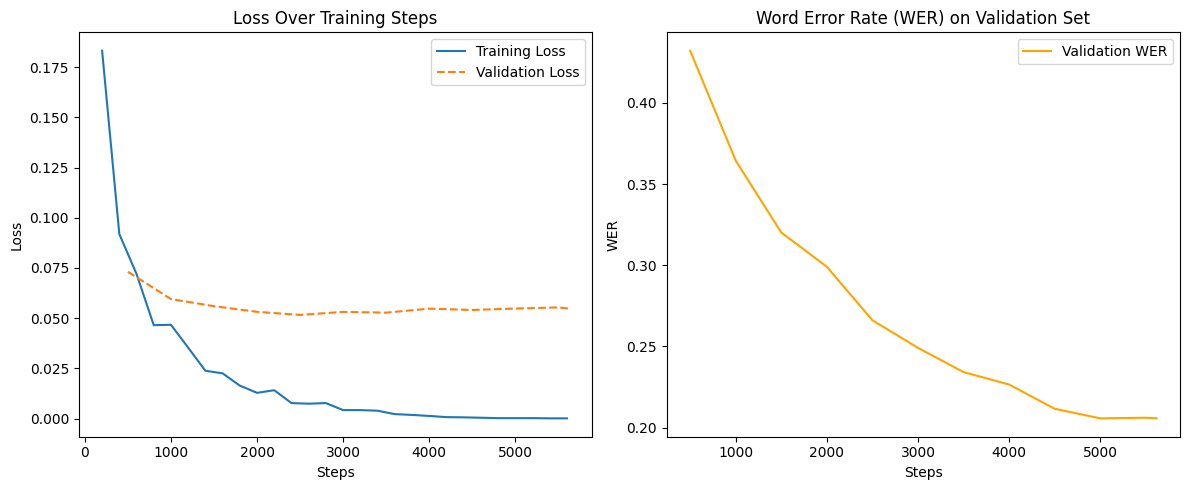

In [ ]:
import matplotlib.pyplot as plt

# Load logs (ensure 'trainer' is defined earlier in your code)
training_logs = trainer.state.log_history  # <-- Make sure 'trainer' exists

# Extract metrics
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
steps = [log['step'] for log in training_logs if 'loss' in log]

eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
eval_wer = [log['eval_wer'] for log in training_logs if 'eval_wer' in log]
eval_steps = [log['step'] for log in training_logs if 'eval_wer' in log]

# Plot
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label='Training Loss')
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Validation Loss', linestyle='--')
plt.title('Loss Over Training Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# WER
if eval_wer:
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, eval_wer, label='Validation WER', color='orange')
    plt.title('Word Error Rate (WER) on Validation Set')
    plt.xlabel('Steps')
    plt.ylabel('WER')
    plt.legend()

plt.tight_layout()
plt.savefig("./whisper_finetuned/training_metrics.png")
plt.show()


In [ ]:
# Step 13: Select a few examples from the validation set for qualitative evaluation
def load_audio_file(file_path):
    array, sampling_rate = librosa.load(file_path, sr=16000)
    return array, sampling_rate

def transcribe_audio(file_path):
    array, sampling_rate = load_audio_file(file_path)

    input_features = processor(array, sampling_rate=sampling_rate, return_tensors="pt").input_features
    input_features = input_features.to(torch.device('cpu'))

    # Generate predictions
    with torch.no_grad():
        generated_ids = model.generate(input_features)

    # Decode predictions
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription

# Pick some random examples from the validation set
example_indices = np.random.choice(len(val_df), size=min(5, len(val_df)), replace=False)
examples = val_df.iloc[example_indices]

results = []
for idx, row in examples.iterrows():
    try:
        reference = row['sentence']
        file_path = row['full_path']

        # Transcribe the audio
        predicted = transcribe_audio(file_path)

        # Compute WER for this example
        wer = wer_metric.compute(predictions=[predicted], references=[reference])

        results.append({
            'file': file_path,
            'reference': reference,
            'prediction': predicted,
            'wer': wer
        })

        # Play the audio
        display(IPythonAudio(filename=file_path))
        print(f"Reference: {reference}")
        print(f"Prediction: {predicted}")
        print(f"WER: {wer}")
        print("-" * 50)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Save the example results
with open("./whisper_finetuned/example_results.json", "w") as f:
    json.dump(results, f, indent=2)

Reference: प्रख्यात ग्रीसका वकिल, साकिस् केचाजिओग्लौ (Sakis Kechagioglou) र जर्ज निकोलाकोपौलस (George Nikolakopoulos)लाई घुस र भ्रष्टाचारको अभियोगमा दोषी ठहरिएका कारण कोरिडेल्लसको एथेन्स जेल (Athens' jail of Korydallus) मा कैद गरिएको छ।
Prediction: प्रख्यात ग्रीषका वकिल, साकिस केचागिगोहोलो र जोर्ज निकोलाका पौलसलाई घुस र भ्राष्टोजारको अभियोगमा दोषित हरिएको कारण कोरिडेलसको एथेन्स जेलमा कहित गरिएको छ।
WER: 0.6666666666666666
--------------------------------------------------


Reference: यस प्रकारको प्रबन्धकलाई असामान्य निर्णयहरू गर्न, अनुशासनिक कारवाही गर्न, कार्य सम्पादन मूल्याङ्कन गर्न, जिम्मेवारी तोक्न र व्यक्तिलाई उत्तरदायी ठहराउन कठीनाइ हुन्छ।
Prediction: यस प्रकारको प्रबन्धकलाई असामान्य निर्णयहरू गर्न अनुशासिक कारवाही गर्न, कार्य सम्पादन मूल्याङ्गन गर्न, जिम्मेवारी तोक्न र व्यक्तिलाई उत्तरदायी ठहराउन कठिनाइ हुन्छ।
WER: 0.19047619047619047
--------------------------------------------------


Reference: लिपिमा भिन्न हुने हिन्दी र उर्दू लेखाइमा समान छन्; दुबै भाषाका वक्ताहरूले दैनिक कुराकानीमा सामान्यतया एक अर्कालाई बुझ्न सक्छन्।
Prediction: लिपोइ इलिपिमा भिन्न हुने हिन्दी र उर्दू लेखाइमा समान छन्; दुबै भाषाका वक्ताहरूले दैनिक कुराकानीमा सामान्यतया एक अर्कालाई बुझ्न सक्छन्।
WER: 0.10526315789473684
--------------------------------------------------


Reference: तपाईंले ट्राभल एजेन्टमार्फत क्याम्पिङ मैदान जस्ता अन्य प्रकारका आवासहरू बुक गर्न सम्भव हुने भए पनि ट्राभल एजेन्टहरूले सामान्यतया निश्चित होटलहरूसँग सम्झौता गरेका हुन्छन्।
Prediction: तपाईंले ट्राभेल एजेन्टमार्फत क्याम्पिङ मैदान जस्ता अन्य प्रकारका आवासहरू बुक गर्न सम्भव हुने भए पनि ट्राभेल एजेन्टहरूले सामान्यतया निश्चित होटलहरूसँग सम्झौता गरेका हुन्छन्।
WER: 0.08695652173913043
--------------------------------------------------


Reference: जसको शक्ति उसकै भक्ति
Prediction: जसको शक्ति उस्कै भक्ति
WER: 0.25
--------------------------------------------------


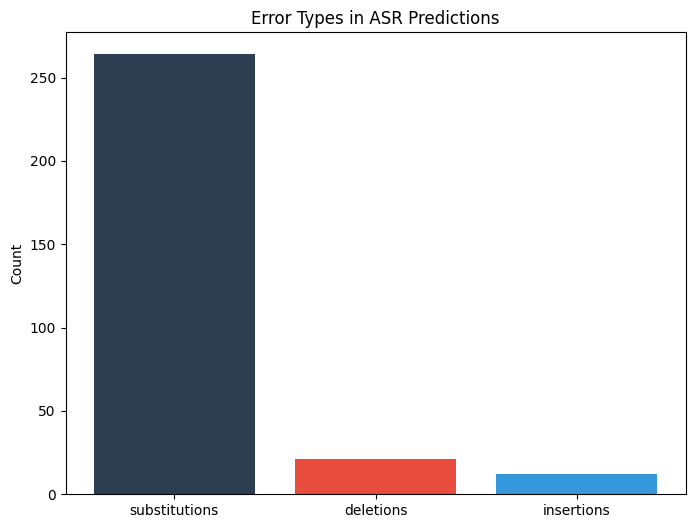

Overall WER on 50 random examples: 0.21728691476590636


In [ ]:
# Step 14: Create a confusion matrix of common error types
def get_error_types(references, predictions):
    # This is a simplified error analysis
    # For a more detailed analysis, you would need to use alignment algorithms
    error_types = {
        'substitutions': 0,
        'deletions': 0,
        'insertions': 0
    }

    for ref, pred in zip(references, predictions):
        ref_words = ref.split()
        pred_words = pred.split()

        # Simple heuristic for error types
        if len(pred_words) < len(ref_words):
            error_types['deletions'] += len(ref_words) - len(pred_words)
        elif len(pred_words) > len(ref_words):
            error_types['insertions'] += len(pred_words) - len(ref_words)

        # Count substitutions (different words at same position)
        min_len = min(len(ref_words), len(pred_words))
        for i in range(min_len):
            if ref_words[i] != pred_words[i]:
                error_types['substitutions'] += 1

    return error_types

# Get more examples for error analysis
error_analysis_size = min(50, len(val_df))
if error_analysis_size > 0:
    analysis_indices = np.random.choice(len(val_df), size=error_analysis_size, replace=False)
    analysis_examples = val_df.iloc[analysis_indices]

    references = []
    predictions = []

    for idx, row in analysis_examples.iterrows():
        try:
            reference = row['sentence']
            file_path = row['full_path']

            # Transcribe the audio
            predicted = transcribe_audio(file_path)

            references.append(reference)
            predictions.append(predicted)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if references and predictions:
        # Get error types
        error_types = get_error_types(references, predictions)

        # Plot error types
        plt.figure(figsize=(8, 6))
        plt.bar(error_types.keys(), error_types.values(), color=['#2C3E50', '#E74C3C', '#3498DB'])
        plt.title('Error Types in ASR Predictions')
        plt.ylabel('Count')
        plt.savefig("./whisper_finetuned/error_types.png")
        plt.show()

        # Calculate overall WER
        overall_wer = wer_metric.compute(predictions=predictions, references=references)
        print(f"Overall WER on {len(references)} random examples: {overall_wer}")

        # Save error analysis results
        error_analysis = {
            'overall_wer': overall_wer,
            'error_types': error_types,
            'examples': [{'reference': ref, 'prediction': pred} for ref, pred in zip(references, predictions)]
        }

        with open("./whisper_finetuned/error_analysis.json", "w") as f:
            json.dump(error_analysis, f, indent=2)

In [ ]:
# Step 15: Create a learning curve to analyze the effect of training data size
def create_learning_curve():
    # Define different dataset sizes
    fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
    wer_results = []

    # Save the original model weights to restore later
    original_weights = {name: param.clone() for name, param in model.named_parameters()}

    for fraction in fractions:
        print(f"Training with {fraction*100}% of the data...")
        # Sample a subset of the training data
        subset_size = int(len(train_df) * fraction)
        subset_df = train_df.sample(n=subset_size, random_state=42)

        # Create a dataset from the subset
        subset_dataset = create_dataset(subset_df)
        subset_dataset = subset_dataset.cast_column("audio", Audio(sampling_rate=16000))
        subset_dataset = subset_dataset.map(prepare_dataset_with_chunking, remove_columns=["audio", "sentence"])

        # Reset the model to initial weights
        for name, param in model.named_parameters():
            param.data.copy_(original_weights[name])

        # Define training arguments for this subset
        subset_training_args = Seq2SeqTrainingArguments(
            output_dir=f"./whisper_finetuned/subset_{fraction}",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            gradient_accumulation_steps=2,
            learning_rate=1e-5,
            max_steps=max(100, int(5308 * fraction)),  # Adjust steps based on fraction
            gradient_checkpointing=True,
            fp16=True,
            eval_strategy="steps",
            eval_steps=max(50, int(500 * fraction)),
            save_steps=max(50, int(500 * fraction)),
            logging_steps=max(10, int(100 * fraction)),
            report_to=["tensorboard"],
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="wer",
            greater_is_better=False,
            push_to_hub=False,
            predict_with_generate=True
        )

        # Create trainer for this subset
        subset_trainer = Seq2SeqTrainer(
            model=model,
            args=subset_training_args,
            train_dataset=subset_dataset,
            eval_dataset=val_dataset,
            tokenizer=processor.feature_extractor,
            compute_metrics=compute_metrics,
        )

        # Train and evaluate
        subset_trainer.train()
        eval_result = subset_trainer.evaluate()
        wer_results.append(eval_result["eval_wer"])

        print(f"WER with {fraction*100}% of data: {eval_result['eval_wer']}")

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot([f*100 for f in fractions], wer_results, marker='o', linestyle='-', color='#3498DB')
    plt.title('Learning Curve: WER vs. Training Data Size')
    plt.xlabel('Percentage of Training Data Used (%)')
    plt.ylabel('Word Error Rate (WER)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./whisper_finetuned/learning_curve.png")
    plt.show()

    # Save learning curve results
    learning_curve_results = {
        'fractions': fractions,
        'wer_results': wer_results
    }

    with open("./whisper_finetuned/learning_curve.json", "w") as f:
        json.dump(learning_curve_results, f, indent=2)

# Uncomment this line to generate the learning curve
# Warning: This will take a lot of time!
create_learning_curve()

Training with 10.0% of the data...


Map:   0%|          | 0/450 [00:00<?, ? examples/s]


TypeError: Invalid file: {'path': 'data\\public_datasets\\merged_dataset\\audio/18033350144519938780.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        6.56843185e-05,  8.94069672e-07, -1.03473663e-04], shape=(156480,)), 'sampling_rate': 16000}

In [ ]:
# Step 16: Add a visualization for confidence scores
def analyze_confidence_scores(num_samples=10):
    """Analyze confidence scores for predictions"""
    if len(val_df) < num_samples:
        num_samples = len(val_df)

    sample_indices = np.random.choice(len(val_df), size=num_samples, replace=False)
    sample_data = val_df.iloc[sample_indices]

    confidence_scores = []
    predictions = []
    references = []
    correct_predictions = []

    for _, row in sample_data.iterrows():
        try:
            file_path = row['full_path']
            reference = row['sentence']

            # Load audio
            array, sampling_rate = load_audio_file(file_path)

            # Get model inputs
            input_features = processor(array, sampling_rate=sampling_rate, return_tensors="pt").input_features
            input_features = input_features.to(torch.device('cpu'))

            # Get model outputs with sequence scores
            with torch.no_grad():
                outputs = model.generate(
                    input_features,
                    return_dict_in_generate=True,
                    output_scores=True,
                    num_beams=5
                )

            # Get the prediction
            predicted_ids = outputs.sequences[0]
            prediction = processor.decode(predicted_ids, skip_special_tokens=True)

            # Calculate average log probability as confidence score
            # Higher score means more confident
            sequence_scores = outputs.sequences_scores[0].item()
            confidence = np.exp(sequence_scores)  # Convert log prob to probability

            predictions.append(prediction)
            references.append(reference)
            confidence_scores.append(confidence)

            # Check if prediction matches reference (simplified)
            wer_value = wer_metric.compute(predictions=[prediction], references=[reference])
            correct = wer_value < 0.5  # Consider it "correct" if WER is below 0.5
            correct_predictions.append(correct)

        except Exception as e:
            print(f"Error analyzing confidence for {file_path}: {e}")

    # Create visualization
    if confidence_scores:
        plt.figure(figsize=(10, 6))

        # Create color map - green for correct predictions, red for incorrect
        colors = ['green' if correct else 'red' for correct in correct_predictions]

        # Create bar chart
        bars = plt.bar(range(len(confidence_scores)), confidence_scores, color=colors)

        # Add labels and styling
        plt.xlabel('Sample Index')
        plt.ylabel('Confidence Score (probability)')
        plt.title('Prediction Confidence Analysis')
        plt.ylim(0, 1.0)

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', label='Correct Prediction (WER < 0.5)'),
            Patch(facecolor='red', label='Incorrect Prediction (WER ≥ 0.5)')
        ]
        plt.legend(handles=legend_elements)

        # Add text annotations
        for i, (conf, pred, ref) in enumerate(zip(confidence_scores, predictions, references)):
            short_pred = pred[:20] + '...' if len(pred) > 20 else pred
            plt.annotate(f"{short_pred}",
                     (i, conf),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center',
                     va='bottom',
                     rotation=90,
                     fontsize=8)

        plt.tight_layout()
        plt.savefig("./whisper_finetuned/confidence_analysis.png")
        plt.show()

        # Save confidence data
        confidence_data = {
            'confidence_scores': confidence_scores,
            'predictions': predictions,
            'references': references,
            'correct_predictions': correct_predictions
        }

        with open("./whisper_finetuned/confidence_analysis.json", "w") as f:
            json.dump(confidence_data, f, indent=2)

# Uncomment to run confidence analysis
analyze_confidence_scores()

c:\Users\Bijay Tamang\Desktop\Nepali-Subtitle-Generator\venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_scores` is. When `return_dict_in_generate` is not `True`, `output_scores` is ignored.
  warnings.warn(


: 

In [ ]:
# Step 17: Create a function to visualize attention weights
def visualize_attention(audio_path):
    """Visualize attention weights for a given audio file"""
    try:
        # Load audio
        array, sampling_rate = load_audio_file(audio_path)

        # Get model inputs
        inputs = processor(array, sampling_rate=sampling_rate, return_tensors="pt")
        input_features = inputs.input_features.to(torch.device('cpu'))

        # Forward pass with output_attentions=True
        with torch.no_grad():
            outputs = model.generate(
                input_features,
                output_attentions=True,
                return_dict_in_generate=True
            )

        # Decode output
        predicted_ids = outputs.sequences[0]
        transcription = processor.decode(predicted_ids, skip_special_tokens=True)

        # Get decoder attention weights from the last layer
        # This is a simplification - attention visualization requires more processing
        # to align with actual tokens
        decoder_attentions = torch.cat([att[-1].mean(dim=1) for att in outputs.decoder_attentions])

        # Plot attention heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(decoder_attentions.cpu().numpy(), cmap='viridis')
        plt.title(f"Decoder Self-Attention\nTranscription: {transcription}")
        plt.ylabel("Output Tokens")
        plt.xlabel("Attention Weights")
        plt.tight_layout()
        plt.savefig("./whisper_finetuned/attention_map.png")
        plt.show()

        return transcription
    except Exception as e:
        print(f"Error visualizing attention: {e}")
        return None

In [ ]:
# Step 18: Function to transcribe a new audio file with the fine-tuned model
def transcribe_new_audio(audio_path):
    array, sampling_rate = load_audio_file(audio_path)

    input_features = processor(array, sampling_rate=sampling_rate, return_tensors="pt").input_features
    input_features = input_features.to(torch.device('cpu'))

    # Generate predictions
    with torch.no_grad():
        generated_ids = model.generate(input_features)

    # Decode predictions
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription

print("Fine-tuning complete! You can now use the model to transcribe new audio files.")
print("Example usage: transcribe_new_audio('/path/to/audio/file.wav')")

Fine-tuning complete! You can now use the model to transcribe new audio files.
Example usage: transcribe_new_audio('/path/to/audio/file.wav')
